In [1]:
import sys
import os
sys.path.append('..')
os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_processing import load_and_clean_data
from src.feature_engineering import KenyanFeatureEngineer

%matplotlib inline
sns.set_style('whitegrid')

df = load_and_clean_data()
print(f"Loaded {len(df):,} customers with {df.shape[1]} features")

[2026-02-20 17:27:45,311] INFO: DataProcessor initialized
[2026-02-20 17:27:45,592] INFO: Successfully loaded data from data/raw/telco_customer_churn.csv
[2026-02-20 17:27:45,593] INFO: Dataset shape: (7043, 21)
[2026-02-20 17:27:45,594] INFO: Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
[2026-02-20 17:27:45,599] INFO: Starting data cleaning...
[2026-02-20 17:27:45,634] INFO: Dropped 0 rows with missing values
[2026-02-20 17:27:45,669] INFO: Removed 0 duplicate rows
[2026-02-20 17:27:45,682] INFO: Churn distribution:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64
[2026-02-20 17:27:45,684] INFO: Data cleaning complete. Final shape: (7043, 21)


Loaded 7,043 customers with 21 features


In [2]:
engineer = KenyanFeatureEngineer()
df_enhanced = engineer.add_kenyan_features(df)
df_final = engineer.create_interaction_features(df_enhanced)

print(f"Original features: {df.shape[1]}")
print(f"Enhanced features: {df_final.shape[1]}")
print(f"New features added: {df_final.shape[1] - df.shape[1]}")

[2026-02-20 17:28:30,275] INFO: Feature engineer initialized
[2026-02-20 17:28:30,277] INFO: Engineering features for 7,043 customers...
[2026-02-20 17:28:30,590] INFO: Added 17 new features


Original features: 21
Enhanced features: 42
New features added: 21


### County Distribution

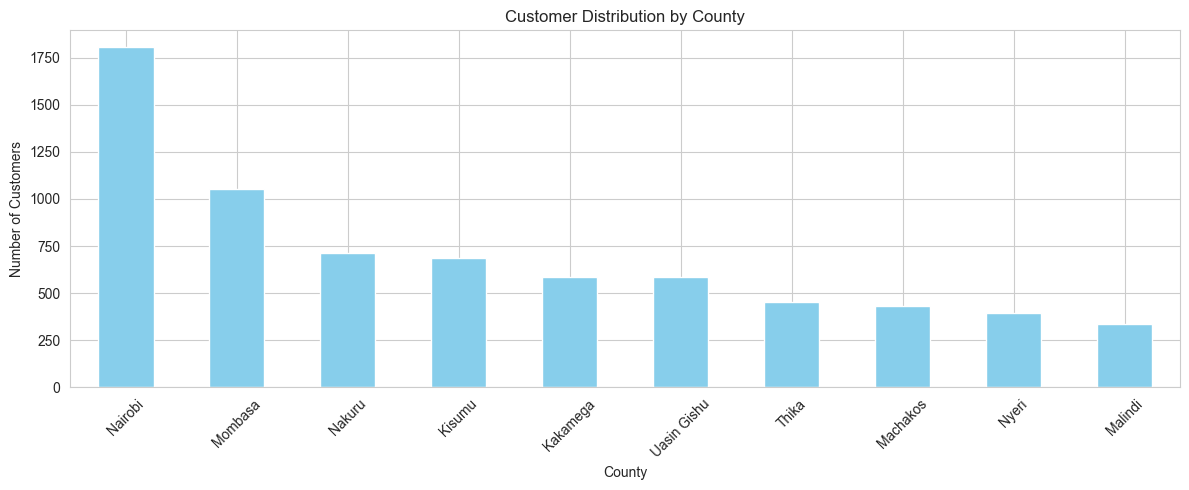


Top 5 counties:
county
Nairobi     1804
Mombasa     1054
Nakuru       713
Kisumu       687
Kakamega     588
Name: count, dtype: int64


In [3]:
plt.figure(figsize=(12, 5))
df_final['county'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Customer Distribution by County')
plt.xlabel('County')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nTop 5 counties:")
print(df_final['county'].value_counts().head())

### Urban vs Rural Distribution

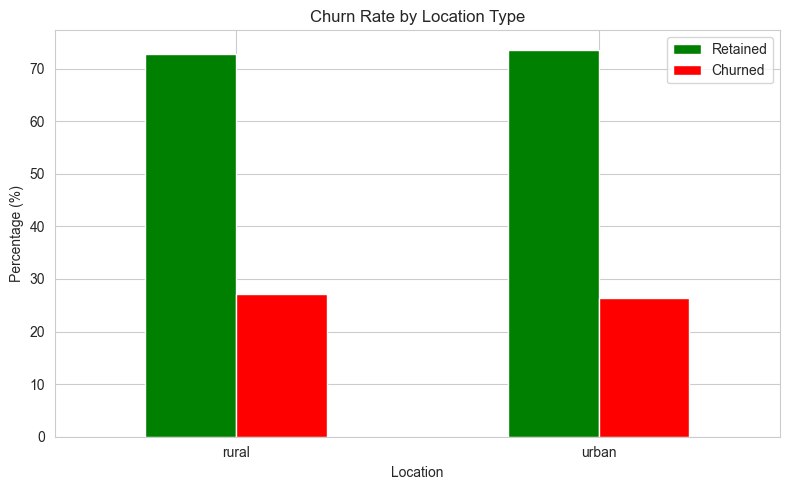

Urban churn rate: 26.4%
Rural churn rate: 27.1%


In [4]:
location_churn = pd.crosstab(df_final['location_type'], df_final['Churn'], normalize='index') * 100

location_churn.plot(kind='bar', color=['green', 'red'], figsize=(8, 5))
plt.title('Churn Rate by Location Type')
plt.xlabel('Location')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(['Retained', 'Churned'])
plt.tight_layout()
plt.show()

print(f"Urban churn rate: {location_churn.loc['urban', 1]:.1f}%")
print(f"Rural churn rate: {location_churn.loc['rural', 1]:.1f}%")

### M-Pesa Usage Patterns

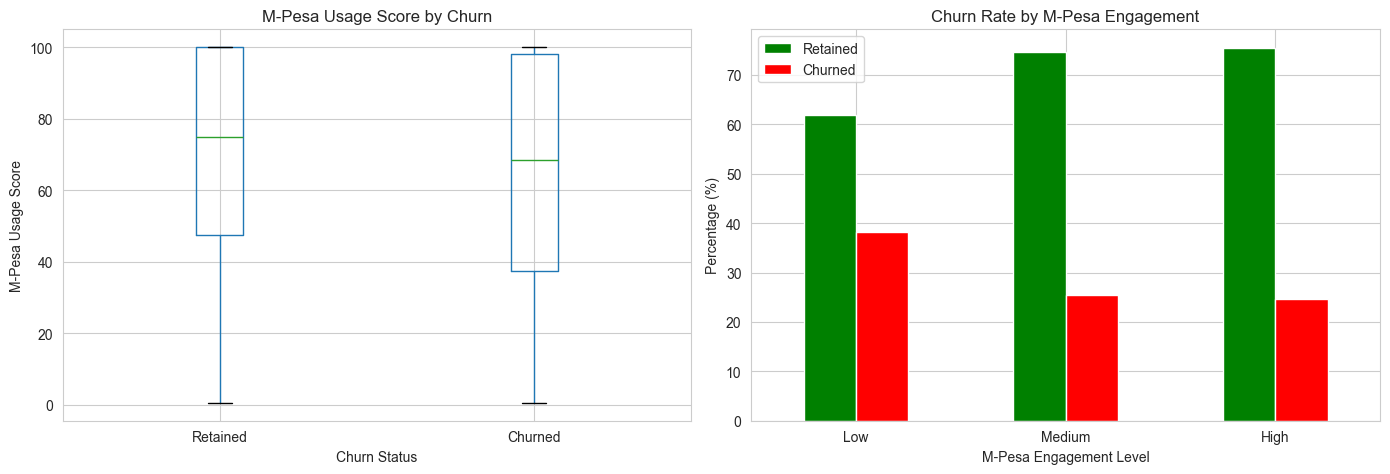

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# M-Pesa usage distribution
df_final.boxplot(column='mpesa_usage_score', by='Churn', ax=axes[0])
axes[0].set_title('M-Pesa Usage Score by Churn')
axes[0].set_xlabel('Churn Status')
axes[0].set_ylabel('M-Pesa Usage Score')
axes[0].set_xticklabels(['Retained', 'Churned'])

# M-Pesa engagement
mpesa_eng = pd.crosstab(df_final['mpesa_engagement'], df_final['Churn'], normalize='index') * 100
mpesa_eng.plot(kind='bar', ax=axes[1], color=['green', 'red'])
axes[1].set_title('Churn Rate by M-Pesa Engagement')
axes[1].set_xlabel('M-Pesa Engagement Level')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xticklabels(['Low', 'Medium', 'High'], rotation=0)
axes[1].legend(['Retained', 'Churned'])

plt.suptitle('')
plt.tight_layout()
plt.show()

**Insight:** Higher M-Pesa usage correlates with lower churn. 

### Bonga points Analysis and Impact

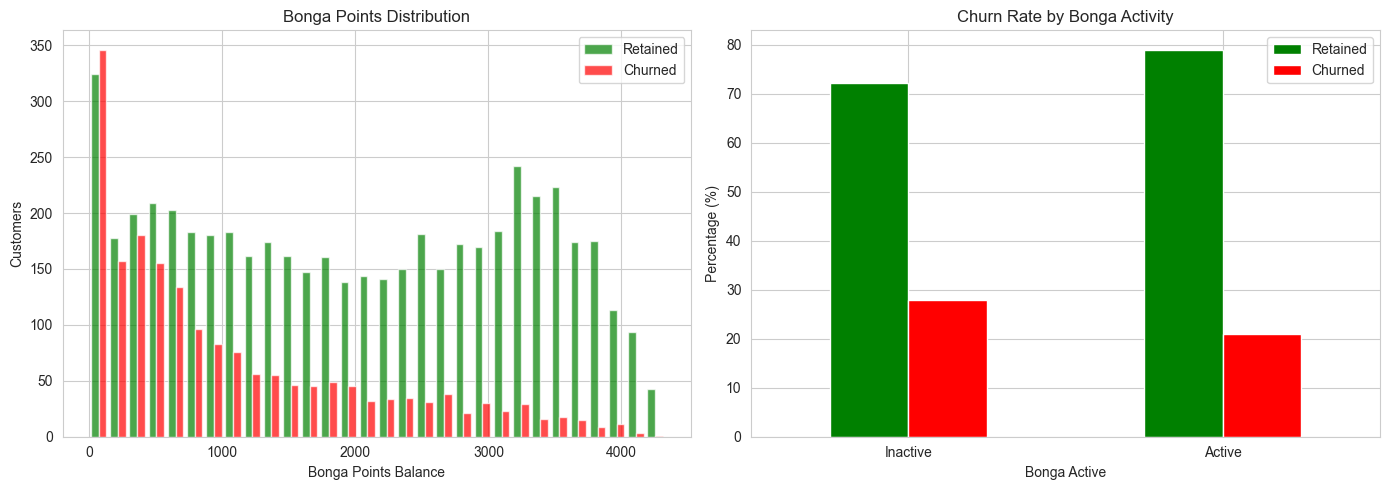

Average Bonga points (Churned): 1048
Average Bonga points (Retained): 2003


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

churned_bonga = df_final[df_final['Churn'] == 1]['bonga_points']
retained_bonga = df_final[df_final['Churn'] == 0]['bonga_points']

axes[0].hist([retained_bonga, churned_bonga], bins=30, label=['Retained', 'Churned'], 
             color=['green', 'red'], alpha=0.7)
axes[0].set_xlabel('Bonga Points Balance')
axes[0].set_ylabel('Customers')
axes[0].set_title('Bonga Points Distribution')
axes[0].legend()


bonga_active = pd.crosstab(df_final['bonga_active'], df_final['Churn'], normalize='index') * 100
bonga_active.plot(kind='bar', ax=axes[1], color=['green', 'red'])
axes[1].set_title('Churn Rate by Bonga Activity')
axes[1].set_xlabel('Bonga Active')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xticklabels(['Inactive', 'Active'], rotation=0)
axes[1].legend(['Retained', 'Churned'])

plt.tight_layout()
plt.show()

print(f"Average Bonga points (Churned): {churned_bonga.mean():.0f}")
print(f"Average Bonga points (Retained): {retained_bonga.mean():.0f}")

**Insight:** Active Bonga users have lower churn.

### Impact of Safaricom home

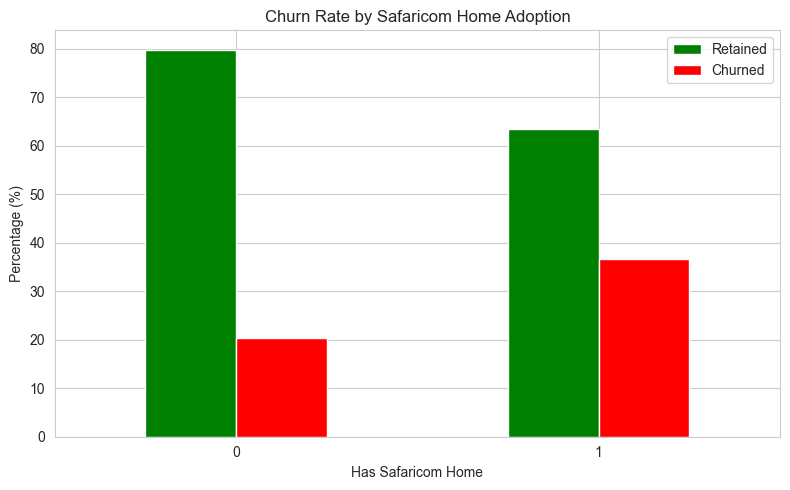

Churn rate (No Safaricom Home): 20.3%
Churn rate (Has Safaricom Home): 36.6%


In [7]:
home_churn = pd.crosstab(df_final['has_safaricom_home'], df_final['Churn'], normalize='index') * 100

home_churn.plot(kind='bar', color=['green', 'red'], figsize=(8, 5))
plt.title('Churn Rate by Safaricom Home Adoption')
plt.xlabel('Has Safaricom Home')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(['Retained', 'Churned'])
plt.tight_layout()
plt.show()

print(f"Churn rate (No Safaricom Home): {home_churn.loc[0, 1]:.1f}%")
print(f"Churn rate (Has Safaricom Home): {home_churn.loc[1, 1]:.1f}%")

**Insight:** Customers with Safaricom Home are less likely to churn (because there are in the eco-system).

### Network Quality Impact 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4944\3318666239.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([retained_nq, churned_nq],


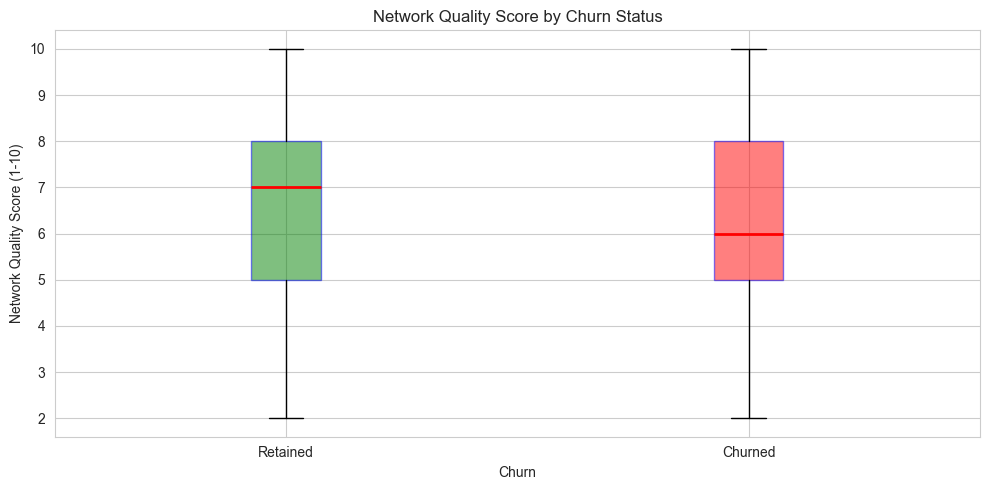

Average network quality (Churned): 6.3
Average network quality (Retained): 6.6


In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

churned_nq = df_final[df_final['Churn'] == 1]['network_quality_score']
retained_nq = df_final[df_final['Churn'] == 0]['network_quality_score']


bp = ax.boxplot([retained_nq, churned_nq], 
                labels=['Retained', 'Churned'],
                patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red', linewidth=2))


bp['boxes'][0].set_facecolor('green')
bp['boxes'][0].set_alpha(0.5)
bp['boxes'][1].set_facecolor('red')
bp['boxes'][1].set_alpha(0.5)

ax.set_title('Network Quality Score by Churn Status')
ax.set_xlabel('Churn')
ax.set_ylabel('Network Quality Score (1-10)')
plt.tight_layout()
plt.show()

print(f"Average network quality (Churned): {churned_nq.mean():.1f}")
print(f"Average network quality (Retained): {retained_nq.mean():.1f}")

**Insight:** Poor network quality is a major churn driver, especially in rural areas.

### Exposure to competitor

<Figure size 1000x500 with 0 Axes>

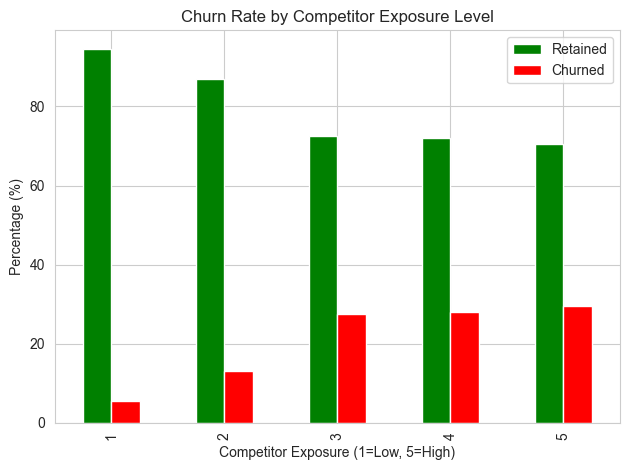

In [9]:
plt.figure(figsize=(10, 5))
comp_churn = pd.crosstab(df_final['competitor_exposure'], df_final['Churn'], normalize='index') * 100

comp_churn.plot(kind='bar', color=['green', 'red'])
plt.title('Churn Rate by Competitor Exposure Level')
plt.xlabel('Competitor Exposure (1=Low, 5=High)')
plt.ylabel('Percentage (%)')
plt.legend(['Retained', 'Churned'])
plt.tight_layout()
plt.show()

**Insight:** Higher competitor exposure increases churn risk.

## Customer Engagement score

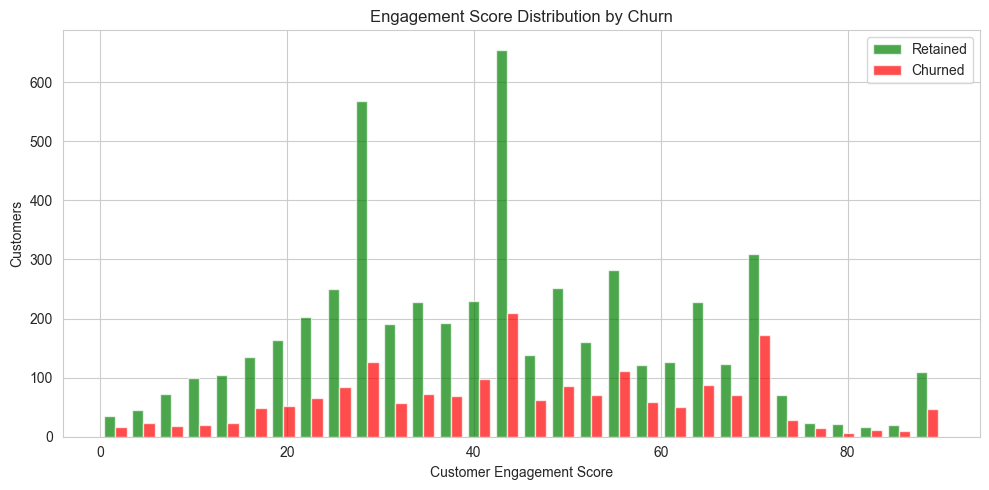

Average engagement (Churned): 45.9
Average engagement (Retained): 42.6


In [10]:
plt.figure(figsize=(10, 5))
churned_eng = df_final[df_final['Churn'] == 1]['customer_engagement_score']
retained_eng = df_final[df_final['Churn'] == 0]['customer_engagement_score']

plt.hist([retained_eng, churned_eng], bins=30, label=['Retained', 'Churned'], 
         color=['green', 'red'], alpha=0.7)
plt.xlabel('Customer Engagement Score')
plt.ylabel('Customers')
plt.title('Engagement Score Distribution by Churn')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Average engagement (Churned): {churned_eng.mean():.1f}")
print(f"Average engagement (Retained): {retained_eng.mean():.1f}")

**Insight:** High engagement with Safaricom ecosystem = strong retention.

In [11]:
engineer.save_enhanced_data(df_final)
print(f"Saved with {df_final.shape[1]} features")

[2026-02-20 17:40:51,566] INFO: Enhanced data saved: data/processed/safaricom_churn_enhanced.csv


Saved with 42 features
